In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq, fsolve, minimize_scalar

## Bachelier (1990), Black (1976), QNM (2023) classes

Bachelier (1990)
\begin{align*}
& dF_t = \sigma_a dW_t \\\\
& C_{BC}(F, K,\sigma_a, r,\tau) = e^{-r\tau} \ [(F-K)N(m_a) + \sigma_a\sqrt{\tau}n(m_a)] \\
& P_{BC}(F, K,\sigma_a, r,\tau) = e^{-r\tau} \ [(K-F)(1-N(m_a)) + \sigma_a\sqrt{\tau}n(m_a)] \\\\
&\textit{ where} \\
&\ m_a = \frac{F-K}{\sigma_a \sqrt{\tau}}
\end{align*} \\

Black (1976)
\begin{align*}
& dF_t = \sigma_G F_tdW_t \\\\
& C_{BL}(F, K,\sigma_G, r,\tau) = e^{-r\tau} \ [FN(m_G + \frac{\sigma_G\sqrt{\tau}}{2}) - KN(m_G - \frac{\sigma_G\sqrt{\tau}}{2})] \\
& P_{BL}(F, K,\sigma_G, r,\tau) = e^{-r\tau} \ [K(1-N(m_G - \frac{\sigma_G\sqrt{\tau}}{2})) - F(1-N(m_G + \frac{\sigma_G\sqrt{\tau}}{2}))] \\\\
& \textit{ where} \\
&\ m_G = \frac{ln(F-K)}{\sigma_G \sqrt{\tau}}
\end{align*} \\


Quadratic Normal Model (Bouchouev, 2023)

\begin{align*}
&dF_t = \sigma(F_t)dW_t = (\sigma_{ATM} + a + bF_t + c F_t^2)dW_t\\\\
&C(F, K, a, b, c, r,\tau) = C_{BC}(F, K, \sigma_a = \sigma_{ATM}, r, \tau) + e^{-r\tau}U\\
&P(F, K, a, b, c, r,\tau) = P_{BC}(F, K, \sigma_a = \sigma_{ATM}, r, \tau) + e^{-r\tau}U\\\\  
& \textit{where}\\
&\ U = \sqrt{\tau}n(\frac{F-K}{\sigma_{ATM}\sqrt{\tau}})[a+\frac{b}{2}(F+K) + \frac{c}{3}(F^2+FK+K^2+\frac{\sigma_{ATM}^2\tau}{2})]
\end{align*}

In [2]:
# Bachelier (1900)
class Bachelier:
    def __init__(self, F, vol, r, tau):
      self.F = F
      self.vol = vol
      self.r = r
      self.tau = tau


    def option_pricer(self, K, vol = None, option_type = 'call'):
      '''
      Bachelier formula
      return call/put option price
      '''
      # default parameter (to compute implied vol)
      if vol == None:
        vol = self.vol

      m = (self.F - K) / (vol * self.tau**0.5)
      if option_type == 'call':
        return np.exp(-self.r * self.tau) * ((self.F - K) * norm.cdf(m) + vol * self.tau**0.5 * norm.pdf(m))
      elif option_type == 'put':
        return np.exp(-self.r * self.tau) * ((K - self.F) * (1 - norm.cdf(m)) + vol * self.tau**0.5 * norm.pdf(m))



# Black (1976)
class Black:
    def __init__(self, F, vol, r, tau):
      self.F = F
      self.vol = vol
      self.r = r
      self.tau = tau


    def option_pricer(self, K, vol = None, option_type = 'call'):
      '''
      Black formula
      return call/put option price
      '''
      # default parameter (to compute implied vol)
      if vol == None:
        vol = self.vol

      m = np.log(self.F / K) / (vol * self.tau**0.5)
      if option_type == 'call':
        return np.exp(-self.r * self.tau) * ( self.F * norm.cdf(m + 0.5*vol*self.tau**0.5) -
                                                    K * norm.cdf(m - 0.5*vol*self.tau**0.5))
      elif option_type == 'put':
        return np.exp(-self.r * self.tau) * ( K * (1 - norm.cdf(m - 0.5*vol*self.tau**0.5)) -
                                                    self.F * (1 - norm.cdf(m + 0.5*vol*self.tau**0.5)))



# Quadratic Normal Model (2023)
class QNM:
    def __init__(self, F, sig_atm, a, b, c, r, tau):
      self.F = F
      self.sig_atm = sig_atm
      self.a = a
      self.b = b
      self.c = c
      self.r = r
      self.tau = tau


    def option_pricer(self, K, option_type = 'call'):
      '''
      The method of linearization
      return call/put option price
      '''
      m = (self.F - K)/(self.sig_atm * self.tau**0.5)
      C_BC = np.exp(-self.r * self.tau) * ((self.F - K)*norm.cdf(m) + self.sig_atm * self.tau**0.5 * norm.pdf(m))
      P_BC = np.exp(-self.r * self.tau) * ((K - self.F)*(1-norm.cdf(m)) + self.sig_atm * self.tau**0.5 * norm.pdf(m))
      U = self.tau**0.5 * norm.pdf(m) * (self.a + self.b*(self.F + K)/2 +
                            self.c*(self.F**2 + self.F*K + K**2 + 0.5*self.sig_atm**2*self.tau)/3)

      if option_type == 'call':
        return C_BC + U*np.exp(-self.r * self.tau)
      elif option_type == 'put':
        return P_BC + U*np.exp(-self.r * self.tau)


## IBV and INV function

In [3]:
# IBV and INV
def implied_volatility(option_price, F, K, r, tau, option_type = 'call', model = 'black', method='brent', disp=True):
    """
        Return Implied volatility
        model: black (default), bachelier
        methods: brent (default), fsolve, minimization
    """
    # model
    if model == 'bachelier':
      bachelier_ = Bachelier(F, 30, r, tau)
      obj_fun = lambda vol : option_price - bachelier_.option_pricer(K = K, vol = vol, option_type = option_type)
    else: # model == 'black'
      black_ = Black(F, 0.1, r, tau)
      obj_fun = lambda vol : option_price - black_.option_pricer(K = K, vol = vol, option_type = option_type)

    # numerical method
    if method == 'minimization':
      obj_square = lambda vol : obj_fun(vol)**2
      res = minimize_scalar( obj_square, bounds=(1e-15, 8), method='bounded')
      if res.success == True:
        return res.x

    elif method == 'fsolve':
        X0 = [0.1, 0.5, 1, 3]   # set of initial guess points
        for x0 in X0:
            x, _, solved, _ = fsolve(obj_fun, x0, full_output=True, xtol=1e-8)
            if solved == 1:
              return x[0]

    else:
        x, r = brentq( obj_fun, a = 1e-15, b = 500, full_output = True)
        if r.converged == True:
          return x

    # display strikes with failed convergence
    if disp == True:
      print(method, K)
    return -1

## Derman's approximation

\begin{align*}
INV(K, F)
& \approx \frac{1}{K-F}\int^K_F\sigma(x)dx\\
& = \frac{1}{K-F}\int^K_F(\sigma_{ATM} + a + bx + c x^2)dx\\
& = \sigma_{ATM} + a + \frac{b}{2}(K+F) + \frac{c}{3}(K^2+KF+F^2)\\
\end{align*}

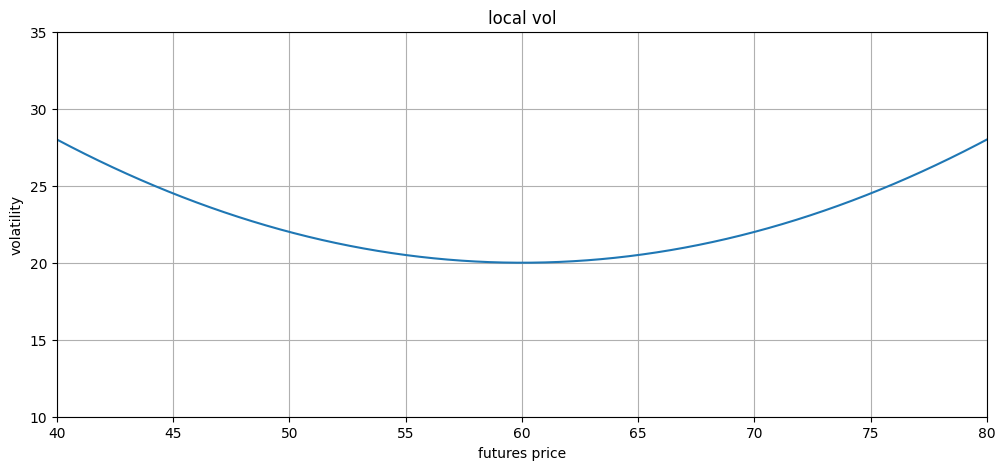

In [4]:
# QNM parameters
sig_atm, a, b, c = 20, 72, -2.4 ,0.02                 # 20 + 0.02*(F-60)^2
futures_price = 60.0
risk_free_rate = 0.0
time_to_maturity = 2.0


# local vol
sig_qnm = lambda f : sig_atm + a + b*f + c*f**2

# Derman's approximation
derman = lambda k : sig_atm + a + b/2*(k + futures_price) + c/3*(k**2 + k*futures_price + futures_price**2)

# Derman's approximation (revised)
derman_revised = lambda k : sig_atm + a + b/2*(k + futures_price) +\
                               c/3*(k**2 + k*futures_price + futures_price**2 + time_to_maturity*sig_atm**2/2)


# plot the local vol
step_f = 0.1
arr_f = np.arange(40, 80 + step_f/2, step_f)

plt.figure(figsize=(12,5))
plt.plot(arr_f, sig_qnm(arr_f))

plt.title('local vol')
plt.xlabel('futures price')
plt.ylabel('volatility')
plt.xlim(40,80)
plt.ylim(10,35)
plt.grid()

plt.show()

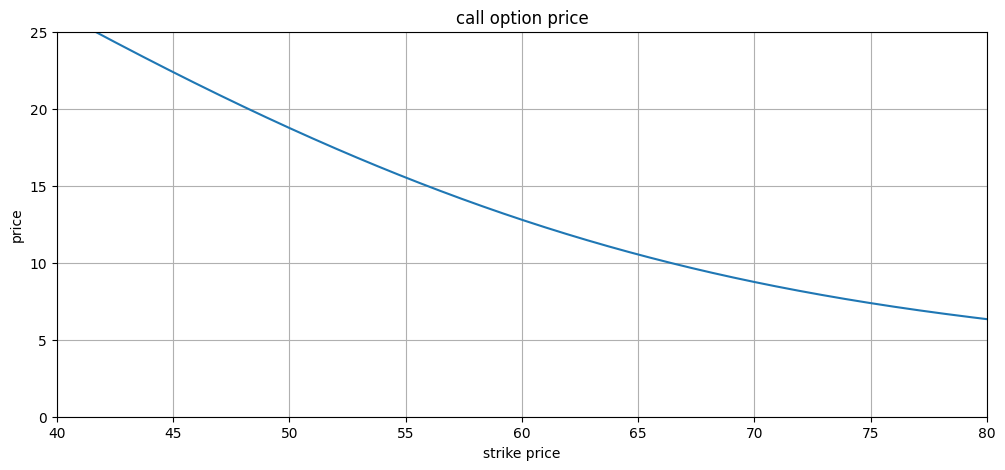

In [5]:
# compute call prices across strikes
qnm = QNM(futures_price, sig_atm, a, b, c, risk_free_rate, time_to_maturity)
arr_qnm_call = qnm.option_pricer(K = arr_f, option_type = 'call')


# plot the call prices
plt.figure(figsize=(12,5))
plt.plot(arr_f, arr_qnm_call)

plt.title('call option price')
plt.xlabel('strike price')
plt.ylabel('price')
plt.xlim(40,80)
plt.ylim(0,25)
plt.grid()

plt.show()

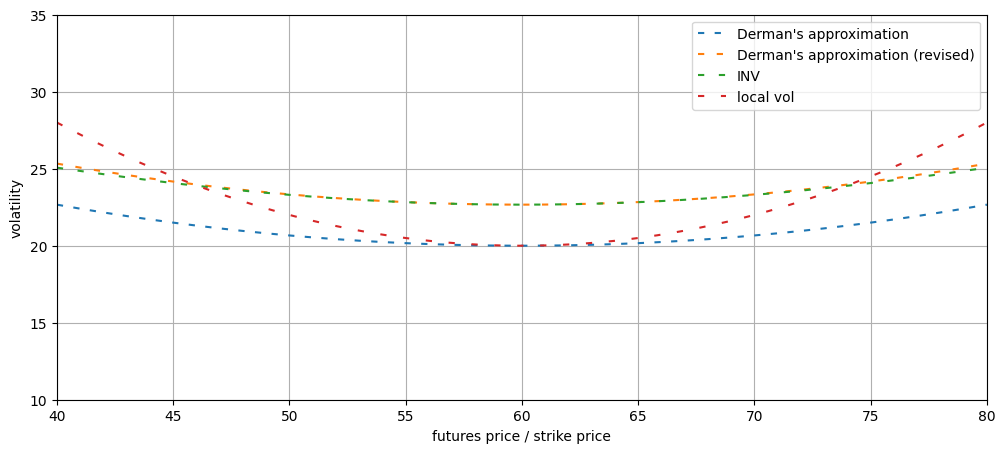

In [6]:
# compute the corresponding INVs across strikes
list_inv_qnm = []
for stirke_, qnm_ in zip(arr_f, arr_qnm_call):
    list_inv_qnm.append(implied_volatility(qnm_, futures_price, stirke_, risk_free_rate, time_to_maturity,
                                                  option_type = 'call', model = 'bachelier', method='brent', disp=True))
arr_inv_qnm = np.array(list_inv_qnm)

# plot the local vol, the INV, and the Derman's approximations
arr_derman = derman(arr_f)
arr_derman_revised = derman_revised(arr_f)
plt.figure(figsize=(12,5))

plt.plot(arr_f, arr_derman, label = 'Derman\'s approximation', linestyle = (0,(3,5)))
plt.plot(arr_f, arr_derman_revised, label = 'Derman\'s approximation (revised)', linestyle = (0,(3,6)))
plt.plot(arr_f, arr_inv_qnm, label = 'INV', linestyle = (0,(3,7)))
plt.plot(arr_f, sig_qnm(arr_f), label = 'local vol', linestyle = (0,(3,8)))

plt.xlabel('futures price / strike price')
plt.ylabel('volatility')
plt.xlim(40,80)
plt.ylim(10,35)
plt.grid()
plt.legend()

plt.show()

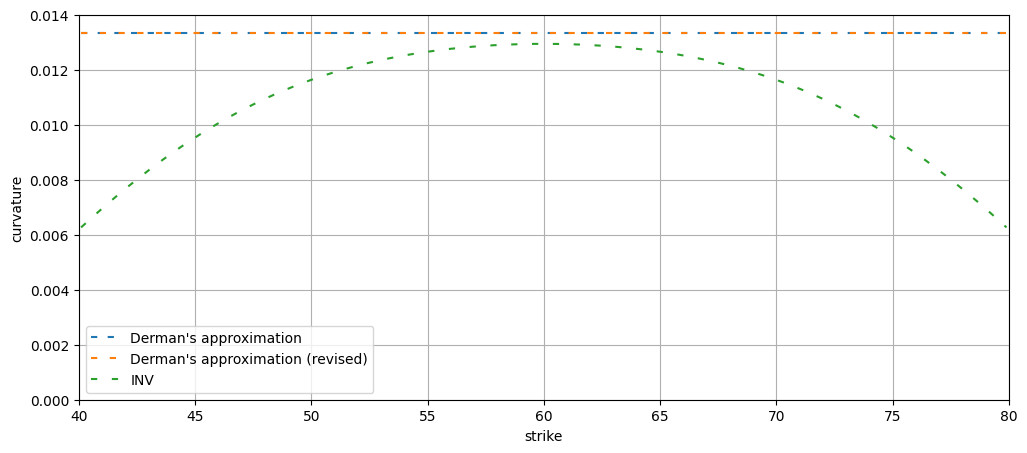

In [7]:
# compute the corresponding curvatures across strikes for INV and Derman's approximations
arr_curve_inv = (arr_inv_qnm[2:] + arr_inv_qnm[:-2] - 2*arr_inv_qnm[1:-1])/step_f**2
arr_curve_derman = (arr_derman[2:] + arr_derman[:-2] - 2*arr_derman[1:-1])/step_f**2
arr_curve_derman_revised = (arr_derman_revised[2:] + arr_derman_revised[:-2] - 2*arr_derman_revised[1:-1])/step_f**2

# plot the curvatures for INV and Derman's approximations
plt.figure(figsize=(12,5))

plt.plot(arr_f[1:-1], arr_curve_derman, label = 'Derman\'s approximation', linestyle = (0,(3,5)))
plt.plot(arr_f[1:-1], arr_curve_derman_revised, label = 'Derman\'s approximation (revised)', linestyle = (0,(3,6)))
plt.plot(arr_f[1:-1], arr_curve_inv, label = 'INV', linestyle = (0,(3,7)))

plt.xlabel('strike')
plt.ylabel('curvature')
plt.xlim(40,80)
plt.ylim(0,0.014)
plt.grid()
plt.legend()

plt.show()

Derman's approximation demonstrates enhanced performance with shorter time to maturity, whereas a more refined strike grid has little impact on the situation.


 time_to_maturity = 0.08333333333333333


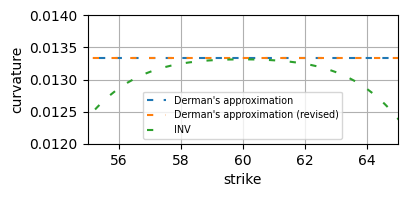


 time_to_maturity = 0.16666666666666666


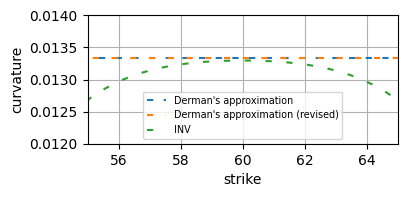


 time_to_maturity = 0.3333333333333333


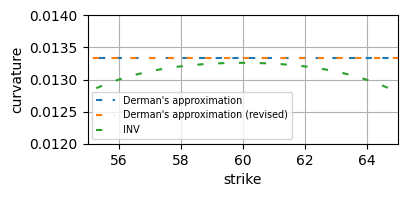


 time_to_maturity = 0.6666666666666666


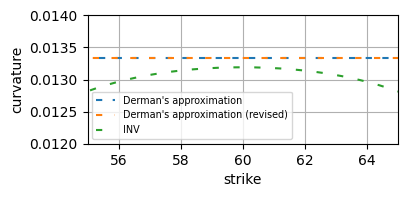

In [8]:
list_time_to_maturity = [1/12, 2/12, 4/12, 8/12]

for time_to_maturity in list_time_to_maturity:

    # compute call prices across strikes
    qnm = QNM(futures_price, sig_atm, a, b, c, risk_free_rate, time_to_maturity)
    arr_qnm_call = qnm.option_pricer(K = arr_f, option_type = 'call')

    # compute the corresponding INVs and Derman's approximations across strikes
    list_inv_qnm = []
    for stirke_, qnm_ in zip(arr_f, arr_qnm_call):
        list_inv_qnm.append(implied_volatility(qnm_, futures_price, stirke_, risk_free_rate, time_to_maturity,
                                                    option_type = 'call', model = 'bachelier', method='brent', disp=True))
    arr_inv_qnm = np.array(list_inv_qnm)
    arr_derman = derman(arr_f)
    arr_derman_revised = derman_revised(arr_f)

    # compute the corresponding curvatures across strikes for INV and Derman's approximation
    arr_curve_inv = (arr_inv_qnm[2:] + arr_inv_qnm[:-2] - 2*arr_inv_qnm[1:-1])/step_f**2
    arr_curve_derman = (arr_derman[2:] + arr_derman[:-2] - 2*arr_derman[1:-1])/step_f**2
    arr_curve_derman_revised = (arr_derman_revised[2:] + arr_derman_revised[:-2] - 2*arr_derman_revised[1:-1])/step_f**2

    # plot the curvatures for INV and Derman's approximation
    print(f'\n time_to_maturity = {time_to_maturity}')
    plt.figure(figsize=(12/3, 5/3))

    plt.plot(arr_f[1:-1], arr_curve_derman, label = 'Derman\'s approximation', linestyle = (0,(3,5)))
    plt.plot(arr_f[1:-1], arr_curve_derman_revised, label = 'Derman\'s approximation (revised)', linestyle = (0,(3,6)))
    plt.plot(arr_f[1:-1], arr_curve_inv, label = 'INV', linestyle = (0,(3,7)))

    plt.xlabel('strike')
    plt.ylabel('curvature')
    plt.xlim(55,65)
    plt.ylim(0.012,0.014)
    plt.grid()
    plt.legend(fontsize = 'x-small')

    plt.show()


 step_f = 0.0125


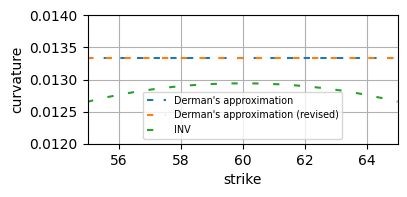


 step_f = 0.025


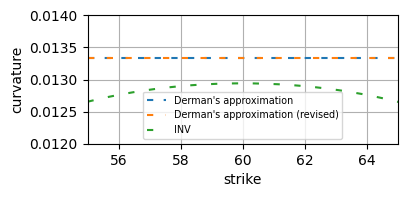


 step_f = 0.05


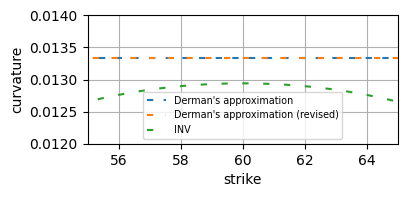


 step_f = 0.1


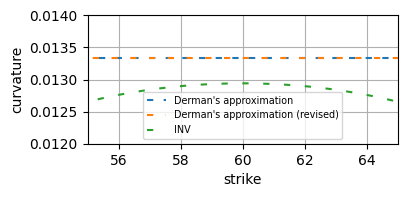

In [9]:
time_to_maturity = 2.0
list_step_f = [0.1/8, 0.1/4, 0.1/2, 0.1]

for step_f in list_step_f:
    arr_f = np.arange(40, 80 + step_f/2, step_f)

    # compute call prices across strikes
    qnm = QNM(futures_price, sig_atm, a, b, c, risk_free_rate, time_to_maturity)
    arr_qnm_call = qnm.option_pricer(K = arr_f, option_type = 'call')

    # compute the corresponding INVs and Derman's approximations across strikes
    list_inv_qnm = []
    for stirke_, qnm_ in zip(arr_f, arr_qnm_call):
        list_inv_qnm.append(implied_volatility(qnm_, futures_price, stirke_, risk_free_rate, time_to_maturity,
                                                    option_type = 'call', model = 'bachelier', method='brent', disp=True))
    arr_inv_qnm = np.array(list_inv_qnm)
    arr_derman = derman(arr_f)
    arr_derman_revised = derman_revised(arr_f)

    # compute the corresponding curvatures across strikes for INV and Derman's approximations
    arr_curve_inv = (arr_inv_qnm[2:] + arr_inv_qnm[:-2] - 2*arr_inv_qnm[1:-1])/step_f**2
    arr_curve_derman = (arr_derman[2:] + arr_derman[:-2] - 2*arr_derman[1:-1])/step_f**2
    arr_curve_derman_revised = (arr_derman_revised[2:] + arr_derman_revised[:-2] - 2*arr_derman_revised[1:-1])/step_f**2

    # plot the curvatures for INV and Derman's approximation
    print(f'\n step_f = {step_f}')
    plt.figure(figsize=(12/3, 5/3))

    plt.plot(arr_f[1:-1], arr_curve_derman, label = 'Derman\'s approximation', linestyle = (0,(3,5)))
    plt.plot(arr_f[1:-1], arr_curve_derman_revised, label = 'Derman\'s approximation (revised)', linestyle = (0,(3,6)))
    plt.plot(arr_f[1:-1], arr_curve_inv, label = 'INV', linestyle = (0,(3,7)))

    plt.xlabel('strike')
    plt.ylabel('curvature')
    plt.xlim(55,65)
    plt.ylim(0.012,0.014)
    plt.grid()
    plt.legend(fontsize = 'x-small')

    plt.show()